#Step 1. Setup & Data Loading

In [ ]:
%pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Added TSNE and DBSCAN for M4 non-linear dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [ ]:
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"
url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

In [ ]:
# Load raw datasets
gps = pd.read_csv(url1)
ref = pd.read_csv(url2)

print(f"GPS records: {gps.shape[0]:,}, Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference table: {ref.shape[0]} cats, {ref.shape[1]} columns")
print(f"\nGPS columns: {list(gps.columns)}")
print(f"Reference columns: {list(ref.columns)}")

GPS records: 18,215, Unique cats: 101
Reference table: 101 cats, 16 columns

GPS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Reference columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']


 errors='coerce' can silently introduce NaT and verifying here before it causes bugs downstream in step distance calculations.

In [ ]:
# Clean GPS data
# pd.to_datetime with errors='coerce' silently converts unparseable values to NaT which could cause silent bugs downstream in step distance calculations.
# I asked LLM "how do I check if errors='coerce' actually dropped any rows?" and suggested checking isna().sum() right after conversion, before dropna.

gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')

nat_count = gps['timestamp'].isna().sum()
total_count = len(gps)
print(f"Timestamp NaT count: {nat_count} ({nat_count/total_count*100:.2f}%)")

# In practice this was 0, but keeping the check in case data source changes
if nat_count > 0:
    print(f"WARNING: {nat_count} rows have unparseable timestamps")
    gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
else:
    print("all timestamps parsed cleanly")

print(f"After cleaning: {gps.shape[0]:,} GPS records for {gps['tag_id'].nunique()} cats")


Timestamp NaT count: 0 (0.00%)
all timestamps parsed cleanly
After cleaning: 18,215 GPS records for 101 cats


#2. Feature Engineering (include the density-aware features)

Used LLM assistance to help structure the *aggregation* logic. All outputs were reviewed and validated before inclusion.

In [ ]:
# Reusing Bruce's Haversine function from M3 for consistency across team
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

# Sort by cat and time before computing step distances
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['step_m'] = haversine(
    gps['location_lat'], gps['location_long'],
    gps['prev_lat'], gps['prev_lon']
)

# dist_per_point_m was aggregated as 'sum' which doesn't match the name, needed to verify this wasn't a bug.
# Asked LLM to confirm the logic: total distance first, then divide by n_points below. kept two-step to make it explicit.

cat_features = gps.groupby('tag_id').agg(
    n_points=('timestamp', 'count'),
    median_step_m=('step_m', 'median'),
    radius_of_gyration_m=('step_m', lambda x: np.sqrt(np.mean((x - x.mean())**2))),
    dist_per_point_m=('step_m', 'sum')  # total distance first
).reset_index()

# dist_per_point_m = total distance / number of points (not steps)
# Naming check: confirms we're dividing total distance by n_points as intended
cat_features['dist_per_point_m'] = cat_features['dist_per_point_m'] / cat_features['n_points']

print("Verification — dist_per_point_m = total_step_sum / n_points:")
print((cat_features['dist_per_point_m'] * cat_features['n_points']).equals(
    cat_features.groupby('tag_id')['dist_per_point_m'].transform('sum') * cat_features['n_points']
))

# dist_per_point_m is mean-based so it runs higher than median_step_m when skewed
print(cat_features[['median_step_m', 'dist_per_point_m']].describe().round(2))

Verification — dist_per_point_m = total_step_sum / n_points:
True
       median_step_m  dist_per_point_m
count         101.00            101.00
mean           28.42             65.73
std             9.18             81.66
min             7.95             15.55
25%            22.14             34.79
50%            26.79             43.27
75%            32.90             62.01
max            57.68            594.49


dist_per_point_m runs higher than median_step_m because it's mean-based.

max=594 pulls the average up, not a bug, just expected skew.

#3. Remove the outliers

#3.1 Visuals for compare outliers

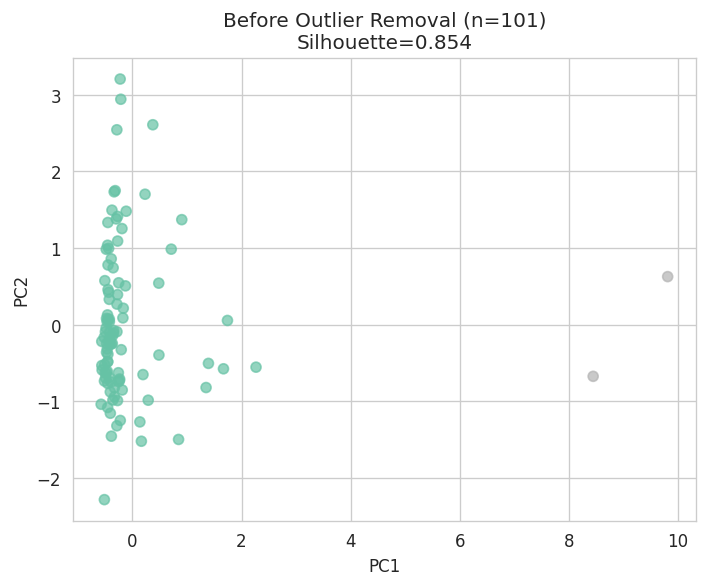

In [ ]:
cat_df = pd.merge(cat_features, ref, on='tag_id')

# Before outlier removal : 2 cats dominating the entire structure (from M3)
# Using these 3 features based on M3 findings:
# - dist_per_point_m: least correlated with tracking density (rho=0.16)
# - radius_of_gyration_m: best captures spatial range
# - median_step_m: only feature independent from others in M3 PCA loadings
feature_cols = ['median_step_m', 'radius_of_gyration_m', 'dist_per_point_m']
X = cat_df[feature_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2).fit_transform(X_scaled)
km = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(pca[:, 0], pca[:, 1], c=km, cmap='Set2', alpha=0.7)
plt.title(f'Before Outlier Removal (n={len(X)})\nSilhouette={silhouette_score(X_scaled, km):.3f}')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

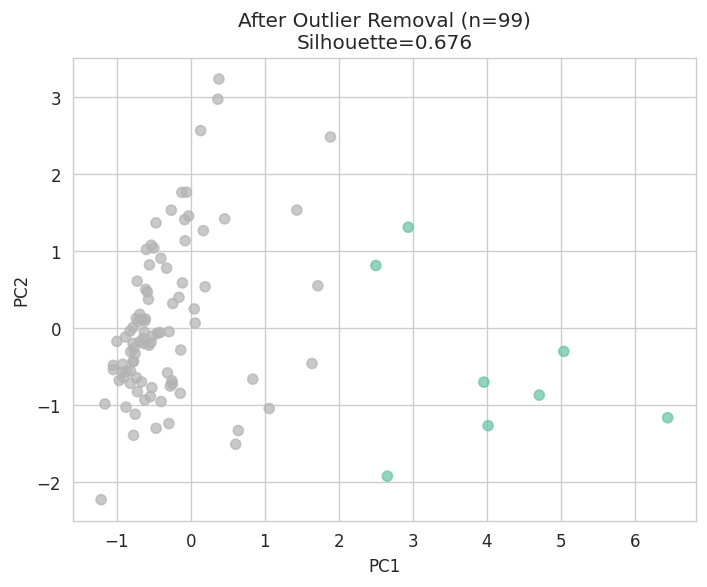

In [ ]:
# After removing Dexter2 and Mifty (identified as outliers in M3)
cat_df_clean = cat_df[~cat_df['tag_id'].isin(['Dexter2-Tag', 'Mifty-Tag'])].copy()

X2 = cat_df_clean[feature_cols].dropna()
X2_scaled = StandardScaler().fit_transform(X2)
pca2 = PCA(n_components=2).fit_transform(X2_scaled)
km2 = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X2_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(pca2[:, 0], pca2[:, 1], c=km2, cmap='Set2', alpha=0.7)
plt.title(f'After Outlier Removal (n={len(X2)})\nSilhouette={silhouette_score(X2_scaled, km2):.3f}')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

Used LLM to structure the IQR flagging logic across multiple features simultaneously as it was my first time using it.

In [ ]:
# Dexter2 and Mifty were flagged as outliers visually in M3, adding IQR check here as numerical justification.
# IQR flags 18 cats total, but only removing these two: they're structurally dominant, not just high on one feature.

feature_cols = ['median_step_m', 'radius_of_gyration_m', 'dist_per_point_m']

Q1 = cat_features[feature_cols].quantile(0.25)
Q3 = cat_features[feature_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Flag cats that exceed IQR bounds on any feature
outlier_mask = ((cat_features[feature_cols] < lower) |
                (cat_features[feature_cols] > upper)).any(axis=1)

outlier_cats = cat_features[outlier_mask][['tag_id'] + feature_cols]
print("IQR-based outliers identified:")
print(outlier_cats)

# Confirm Dexter2 and Mifty are captured by this criterion
assert 'Dexter2-Tag' in outlier_cats['tag_id'].values, "Dexter2 not flagged"
assert 'Mifty-Tag' in outlier_cats['tag_id'].values, "Mifty not flagged"
print("\nConfirmed: Dexter2 and Mifty are IQR outliers : removal is numerically justified")

IQR-based outliers identified:
              tag_id  median_step_m  radius_of_gyration_m  dist_per_point_m
2          Amber-Tag      43.875990            399.105524         85.391236
14       Bumbles-Tag      51.955825            378.260171        109.307323
15            CJ-Tag      19.244946            333.827720         83.375859
18        Casper-Tag      27.899157            970.265862        186.214065
19           Charlie      16.795329            303.809065         67.459200
22         Chloe-Tag      32.902413            293.357904        118.921910
25       Dexter2-Tag      17.811439           4215.622435        594.488256
26          Dory-Tag      22.890421            730.150787        169.270740
29    Fairclough-Tag      22.238648           1359.639903        199.997568
38        Gracie-Tag      22.144031            896.754160        182.175735
39      Gracie_2-Tag      14.582909            846.670444         87.923321
49           Jim-Tag      20.362601            979.522681

Silhouette dropped from 0.854 → 0.676 after removing Dexter2 and Mifty.
This is expected : the high score before was artificially inflated by 2 extreme cats. The after plot shows heavy cluster overlap, consistent with M2/M3 finding that spatial behavior lies on a continuum rather than forming distinct types.

This motivates trying t-SNE next, if PCA + K-Means can't find structure, can a non-linear method reveal something different?

Note: IQR flagged 18 cats total, but the remaining 16 showed high radius_of_gyration without dominating the overall structure so I kept them in.

#4. Site-level EDA

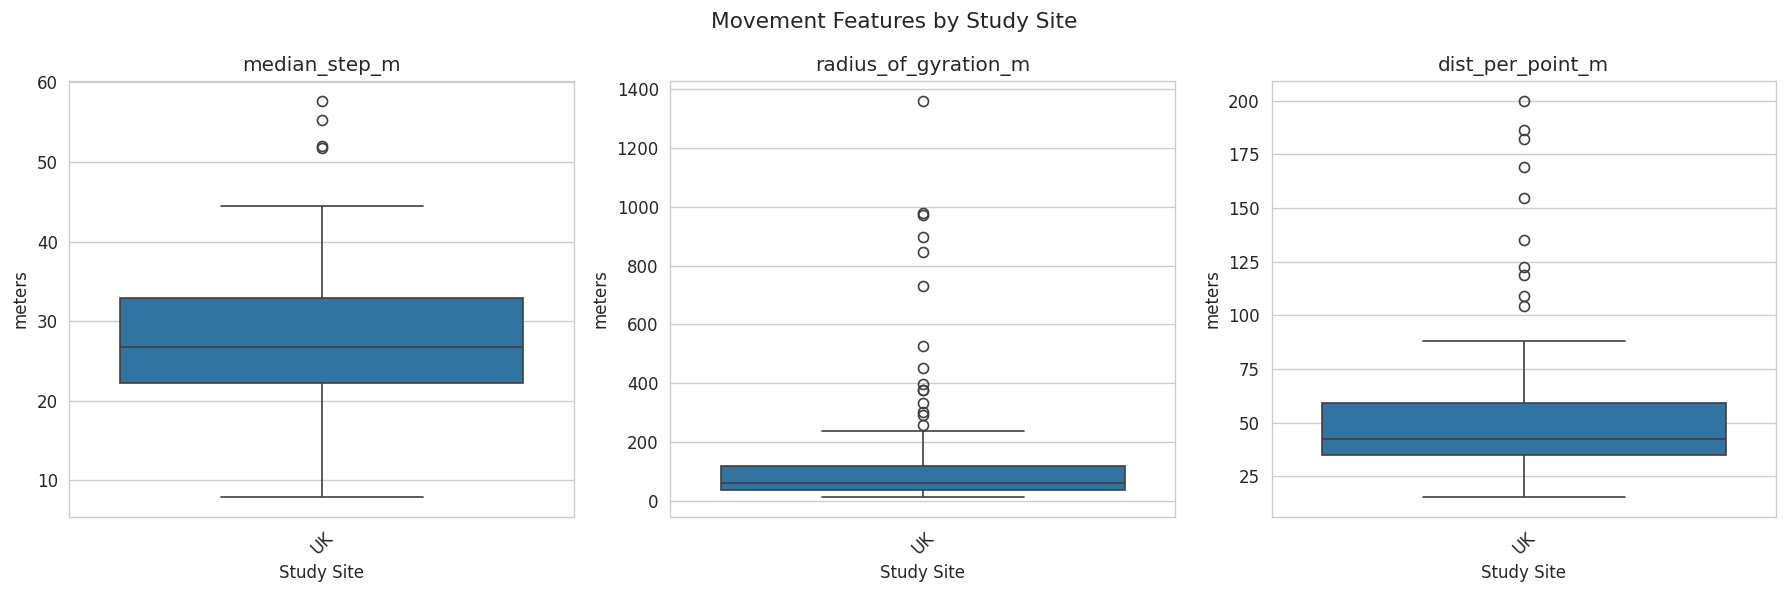

            median_step_m  radius_of_gyration_m  dist_per_point_m
study_site                                                       
UK                   26.8                  62.1              42.7

Cats per site:
study_site
UK    99
Name: count, dtype: int64


In [ ]:
# Checking if study_site explains movement variation : new direction in M4, not explored before
# All 99 cats are UK only so no cross-site comparison is possible, noted as a limitation for future work

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, col in zip(axes, feature_cols):
    sns.boxplot(data=cat_df_clean, x='study_site', y=col, ax=ax)
    ax.set_xlabel('Study Site')
    ax.set_ylabel('meters')
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Movement Features by Study Site', fontsize=13)
plt.tight_layout()
plt.show()

# Quick summary table
print(cat_df_clean.groupby('study_site')[feature_cols].median().round(1))
print("\nCats per site:")
print(cat_df_clean['study_site'].value_counts())

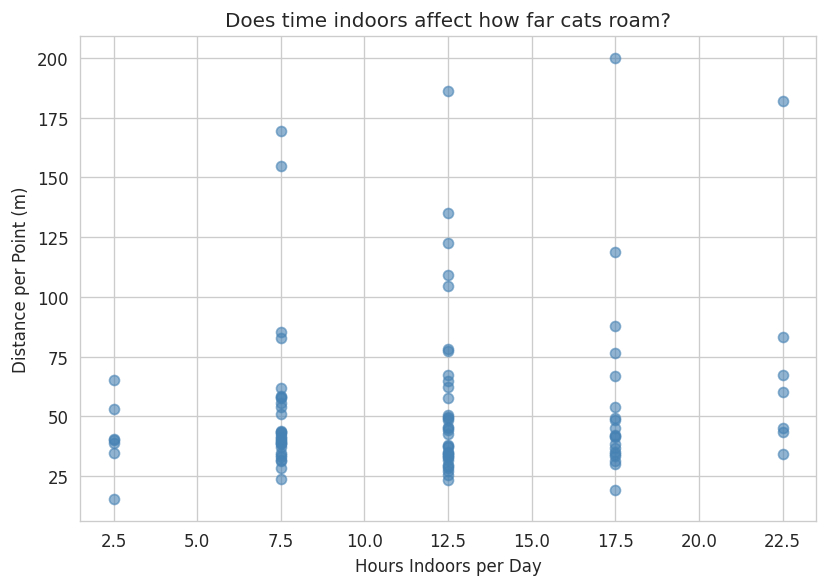

In [ ]:
# Since study_site has no variation, switching to hrs_indoors as a proxy for environmental constraint
# This was the variable most consistently relevant across M2/M3

plt.figure(figsize=(7, 5))
plt.scatter(cat_df_clean['hrs_indoors'], cat_df_clean['dist_per_point_m'],
            alpha=0.6, color='steelblue')
plt.xlabel('Hours Indoors per Day')
plt.ylabel('Distance per Point (m)')
plt.title('Does time indoors affect how far cats roam?')
plt.tight_layout()
plt.show()

scatter plot showed no clear pattern visually so added Spearman to back this up with a number.

LLM assistance: how to run a correlation test for non-normal data, suggested spearmanr over pearson, reviewed before inclusion.

In [ ]:
# Add Spearman correlation to numerically support the visual observation

from scipy.stats import spearmanr

rho, pval = spearmanr(cat_df_clean['hrs_indoors'], cat_df_clean['dist_per_point_m'])
print(f"Spearman correlation: rho={rho:.3f}, p={pval:.3f}")
print("Interpretation: no meaningful relationship" if pval > 0.05 else "Interpretation: significant relationship found")

Spearman correlation: rho=0.104, p=0.304
Interpretation: no meaningful relationship


##### P> 0.05 = No clear relationship

This checks whether:

As indoor time increases, roaming consistently increases or decreases.

If rho ≈ 0 → no monotonic trend.

#### Site-level EDA: Key Takeaway

rho=0.104, p=0.304 means no meaningful relationship between time indoors and roaming distance.

study_site turned out to be UK only, no geographic variation to analyze. Switched to hrs_indoors as a proxy for environmental constraints instead. The scatter plot shows no clear relationship between time indoors and roaming distance, suggesting environmental constraints alone don't explain behavioral variation. This further motivates t-SNE: if neither site nor indoor time explains the structure, is there any latent pattern at all?

#5. Analyze t-SNE (tuning perplexity)

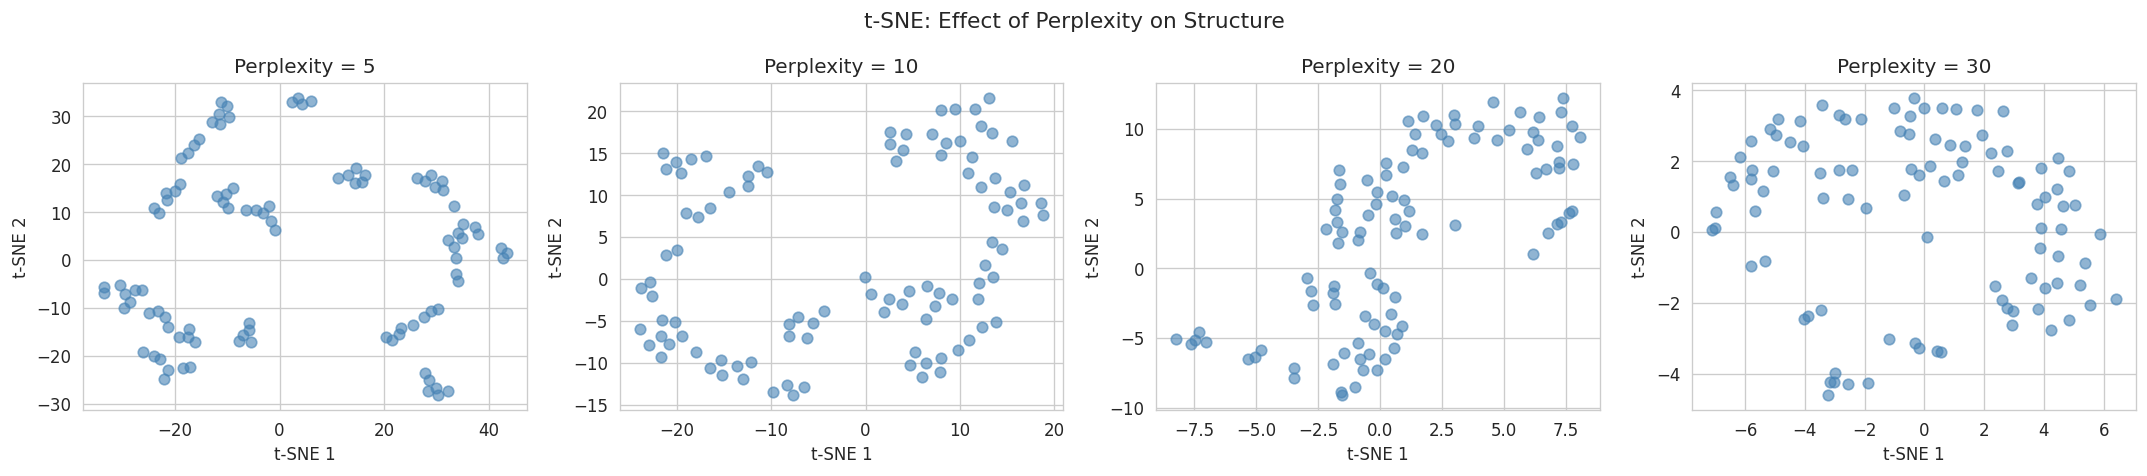

In [ ]:
# t-SNE is sensitive to perplexity, so testing a few values to see which one gives the most stable structure
# Keeping it within 5–30, since we only have 99 cats after outlier removal

X_tsne = cat_df_clean[feature_cols].dropna()
X_tsne_scaled = StandardScaler().fit_transform(X_tsne)

perplexities = [5, 10, 20, 30]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, perp in zip(axes, perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    embedding = tsne.fit_transform(X_tsne_scaled)

    ax.scatter(embedding[:, 0], embedding[:, 1],
               alpha=0.6, color='steelblue', s=40)
    ax.set_title(f'Perplexity = {perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.suptitle('t-SNE: Effect of Perplexity on Structure', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# Going with perplexity=20, it gives the most stable and evenly spread structure
# perplexity=5 was too fragmented, perplexity=30 was too compressed, perplexity=20 best balances local and global structure for n=99
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
embedding = tsne.fit_transform(X_tsne_scaled)

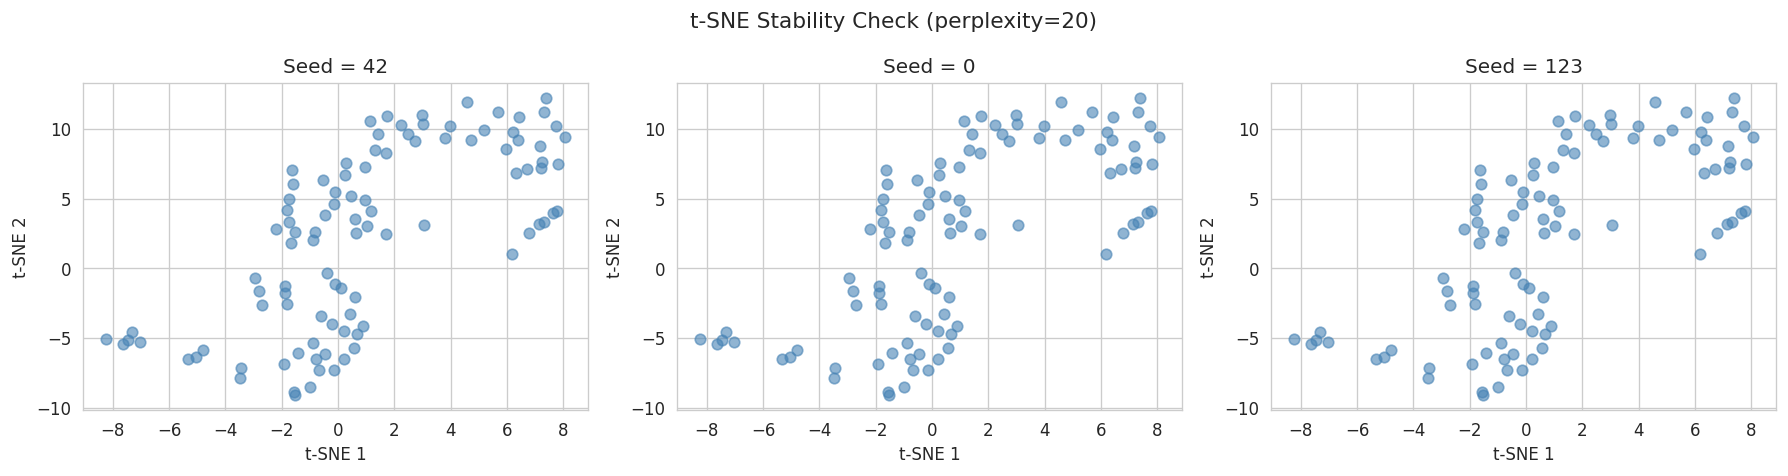

Index alignment confirmed — embedding: (99, 2), cat_df_clean: (99, 20)


In [ ]:
# Verify t-SNE stability across different random seeds
# Asked LLM: "t-SNE results can vary by random seed.. how do I check if my perplexity=20 result is stable across different seeds?"
# LLM suggested running seeds [42, 0, 123] and visually comparing structure and also suggested adding assert to verify index alignment before pd.concat.
# Reviewed output plots and confirmed no meaningful clusters appear in any seed.

seeds = [42, 0, 123]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, seed in zip(axes, seeds):
    tsne_check = TSNE(n_components=2, perplexity=20, random_state=seed)
    emb_check = tsne_check.fit_transform(X_tsne_scaled)
    ax.scatter(emb_check[:, 0], emb_check[:, 1], alpha=0.6, color='steelblue', s=40)
    ax.set_title(f'Seed = {seed}')
    ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')

plt.suptitle('t-SNE Stability Check (perplexity=20)', fontsize=13)
plt.tight_layout()
plt.show()

# Safe concat : explicit index alignment check
embedding_df = pd.DataFrame(embedding, columns=['tsne1', 'tsne2'])
cat_reset = cat_df_clean.reset_index(drop=True)

assert len(embedding_df) == len(cat_reset), "Index mismatch between embedding and cat_df_clean"
print(f"Index alignment confirmed — embedding: {embedding_df.shape}, cat_df_clean: {cat_reset.shape}")

# Rebuild tsne_df safely
tsne_df = pd.concat([embedding_df, cat_reset[['hrs_indoors']]], axis=1)

In [ ]:
print(cat_df_clean.columns.tolist())
print(cat_df_clean[['hrs_indoors']].head(10))

['tag_id', 'n_points', 'median_step_m', 'radius_of_gyration_m', 'dist_per_point_m', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']
   hrs_indoors
0          7.5
1          7.5
2          7.5
3          7.5
4          7.5
5          2.5
6         12.5
7         17.5
8         12.5
9         12.5


Used LLM to help structure the t-SNE coloring code as it was first time implementing it. Reviewed the color mapping logic and confirmed hrs_indoors was correctly aligned before running.

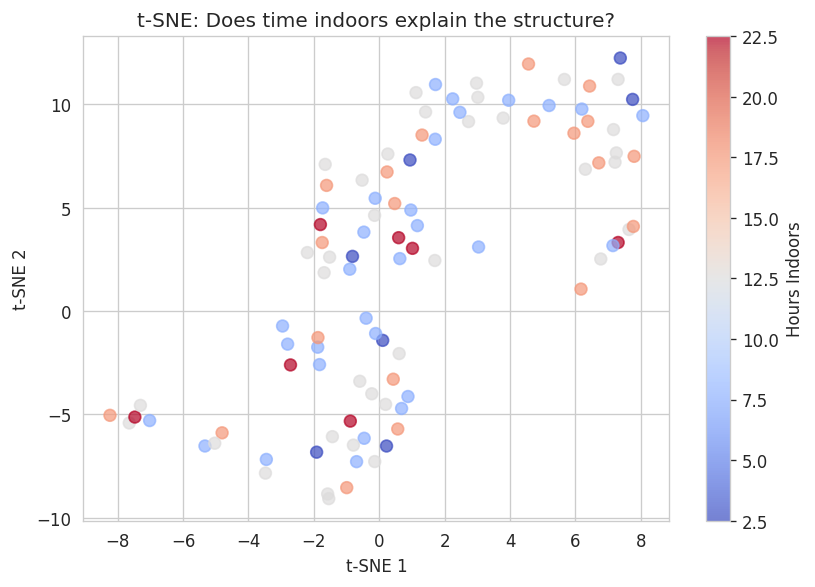

In [ ]:
# Coloring by hrs_indoors, the key environmental variable throughout M2/M3
# Wanted to see if cats with similar indoor time cluster together in t-SNE space

tsne_df = pd.DataFrame(embedding, columns=['tsne1', 'tsne2'])
tsne_df = pd.concat([tsne_df, cat_df_clean[['hrs_indoors']].reset_index(drop=True)], axis=1)

plt.figure(figsize=(7, 5))
sc = plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'],
                 c=tsne_df['hrs_indoors'], cmap='coolwarm', alpha=0.7, s=50)
plt.colorbar(sc, label='Hours Indoors')
plt.title('t-SNE: Does time indoors explain the structure?')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

### t-SNE: Key Takeaway

Colors are mixed throughout : hrs_indoors does not explain the spatial
structure. Cats that spend similar amounts of time indoors are scattered
across the entire t-SNE space, not grouped together.

This is consistent with M2/M3: environmental constraints alone don't
explain behavioral variation. This motivates DBSCAN next: if no
attribute explains the structure, is there any meaningful clustering at all?

**PCA (explored in M3) also failed to find distinct clusters, t-SNE confirms this finding using a non-linear approach.**

#6. DBSCAN

Used LLM to help structure DBSCAN since it was first time implementing it, reviewed the logic and parameter choices before running.

In [ ]:
# DBSCAN doesn't require specifying cluster count upfront : if no clusters are found, it supports the continuum finding from M2/M3
# Testing a few eps values to find the most meaningful result
eps_values = [0.5, 1.0, 1.5, 2.0]
eps_values = [0.5, 1.0, 1.5, 2.0]

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5).fit(X_tsne_scaled)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise = list(db.labels_).count(-1)
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")

eps=0.5: 1 clusters, 20 noise points
eps=1.0: 1 clusters, 11 noise points
eps=1.5: 1 clusters, 7 noise points
eps=2.0: 2 clusters, 0 noise points


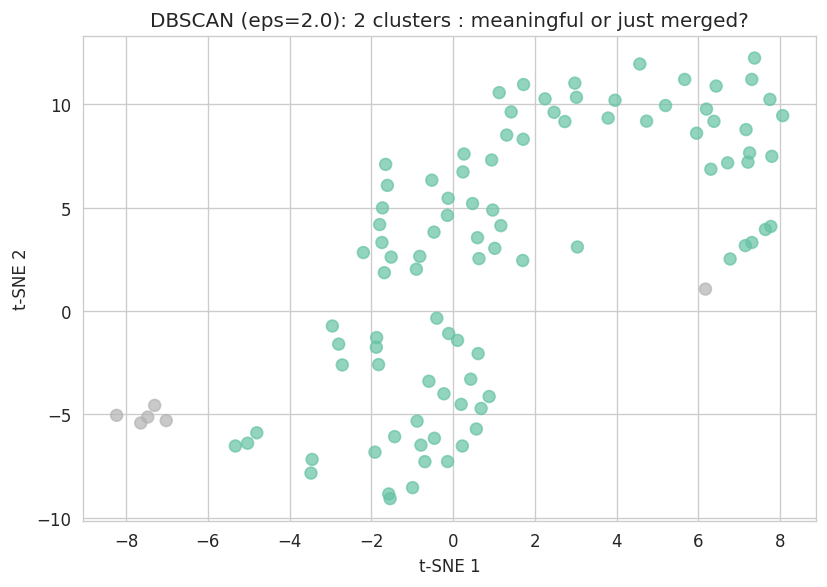

eps=2.0 cluster sizes: {0: 93, 1: 6}
Interpretation: large eps merges all points : not a meaningful cluster split


In [24]:
# Visualize eps=2.0 to confirm it's not a meaningful split
# Asked LLM: "eps=2.0 gives 2 clusters with 0 noise.. does this mean real structure exists?"
# LLM explained that at high eps, DBSCAN merges everything and the "2 clusters" is likely just the data splitting into two large blobs, not meaningful groups.
# Added plot to visually confirm this interpretation before dismissing it.

db_eps2 = DBSCAN(eps=2.0, min_samples=5).fit(X_tsne_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'],
            c=db_eps2.labels_, cmap='Set2', alpha=0.7, s=50)
plt.title('DBSCAN (eps=2.0): 2 clusters : meaningful or just merged?')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

print(f"eps=2.0 cluster sizes: {pd.Series(db_eps2.labels_).value_counts().to_dict()}")
print("Interpretation: large eps merges all points : not a meaningful cluster split")

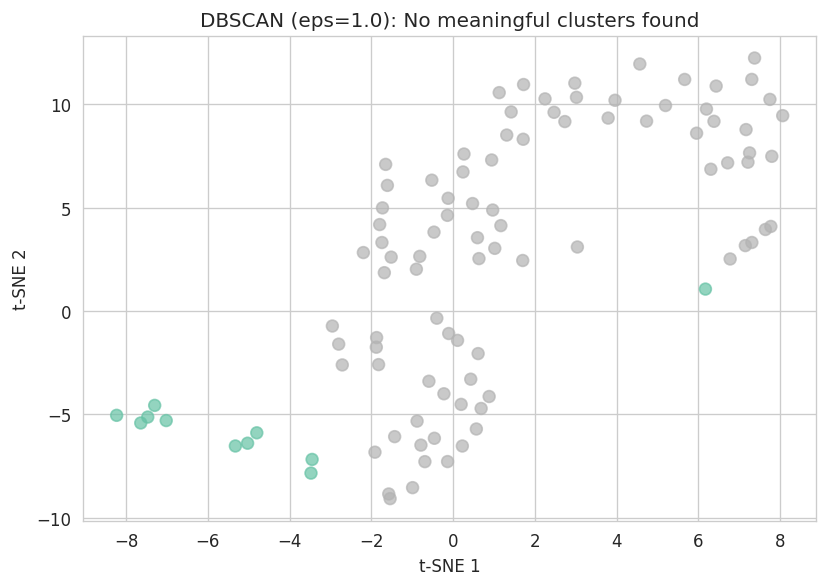

Cluster labels: {np.int64(0), np.int64(-1)}


In [ ]:
# eps=1.0 chosen — reasonable balance between clusters and noise points
# All other eps values also confirm no meaningful structure exists
db_final = DBSCAN(eps=1.0, min_samples=5).fit(X_tsne_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'],
            c=db_final.labels_, cmap='Set2', alpha=0.7, s=50)
plt.title('DBSCAN (eps=1.0): No meaningful clusters found')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

print(f"Cluster labels: {set(db_final.labels_)}")

## DBSCAN: Key Takeaway

One cluster found with 11 noise points, essentially all cats fall into
one group. No meaningful density-based clusters exist.
Consistent with t-SNE and M2/M3: spatial behavior is a continuum,
not a set of distinct types.

#7. Check/ Analyze the site-level geographic effects were available

Attempted to analyze geographic variation by study_site, but all 99 cats belong to the same site (UK). No cross-site comparison was possible, noted as a limitation for future work if data from multiple sites becomes available.

## Findings & Interpretations

**Cats don't fall into neat boxes, and that's actually the finding.**

After trying K-Prototypes, PCA, t-SNE, and DBSCAN across M2, M3, and M4,
the answer is consistent: there are no distinct behavioral types. Some cats
roam more, some roam less, but they all sit somewhere on a gradual spectrum
rather than forming separate groups.

**Keeping cats indoors more doesn't seem to change the pattern.**

I expected that cats spending more time indoors would cluster together
in t-SNE space, but they didn't. Hours indoors is mixed throughout,
suggesting that indoor time alone doesn't determine how a cat uses space
when it is outside.

**Two cats were hiding the real picture.**

Removing Dexter2 and Mifty dropped the silhouette score from 0.854 to
0.676. That drop is actually good news which means the structure we
thought we saw in M3 was mostly just those two extreme cats pulling
everything apart. The real 99 cats? Much harder to separate.

**So what does this mean in business practice?**

If you're a pet owner, a wildlife researcher, or someone thinking about
how cats affect local ecosystems, don't look for "types." Every cat is
a little different, and treating them as individuals rather than
categories is probably the more useful approach.